# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [2]:
def entropy(class_counts):
  total_count = sum(class_counts)
  if total_count == 0:
    return 0
  probabilities = [count / total_count for count in class_counts]
  entropy = -sum([p * np.log2(p) if p > 0 else 0 for p in probabilities])
  return entropy

class_counts = [8, 2]

impurity = entropy(class_counts)

print(f"The impurity of the node (entropy) is: {impurity}")

The impurity of the node (entropy) is: 0.7219280948873623


**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [3]:
def gini_impurity(class_counts):
  total_count = sum(class_counts)
  if total_count == 0:
    return 0
  probabilities = [count / total_count for count in class_counts]
  gini = 1 - sum([p**2 for p in probabilities])
  return gini

# Node V
total_count_v = 10
class_counts_v = [8, 2]
h_v = gini_impurity(class_counts_v)

# Left subtree VL
total_count_vl = 8
class_counts_vl = [8, 0]
h_vl = gini_impurity(class_counts_vl)

# Right subtree VR
total_count_vr = 2
class_counts_vr = [0, 2]
h_vr = gini_impurity(class_counts_vr)

q = h_v - (total_count_vl / total_count_v) * h_vl - (total_count_vr / total_count_v) * h_vr

print(f"The information gain criterion Q is: {q}")

The information gain criterion Q is: 0.31999999999999984


**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [4]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = np.mean(target_values)
print(f"The model's prediction for these objects will be: {prediction}")

The model's prediction for these objects will be: 40.6


## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [5]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [6]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [7]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


In [8]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-8-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


In [9]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [10]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


In [11]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [16]:
transform.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [17]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [18]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [26]:
dt_classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 5, 10]},
             scoring='f1')

In [27]:
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1}


In [28]:
best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train_transformed, y_train)

X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())

In [29]:
y_pred = best_dt_classifier.predict(X_test_transformed)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"AUC ROC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.8417061195861827
Recall: 0.17593107281823236
Precision: 0.4949179046129789
AUC ROC: 0.5711548775145602


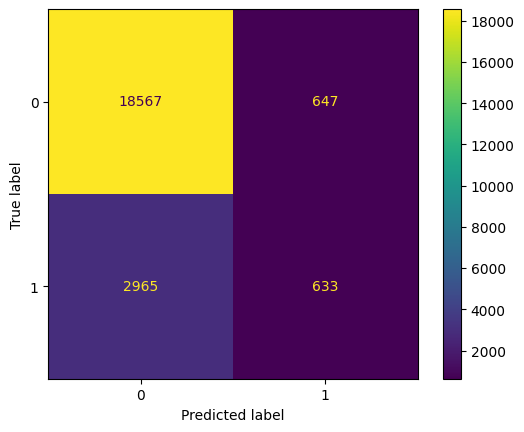

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_search.best_estimator_.predict(X_test_transformed))

In [33]:
recall_score(y_test, grid_search.best_estimator_.predict(X_test_transformed))

0.17593107281823236

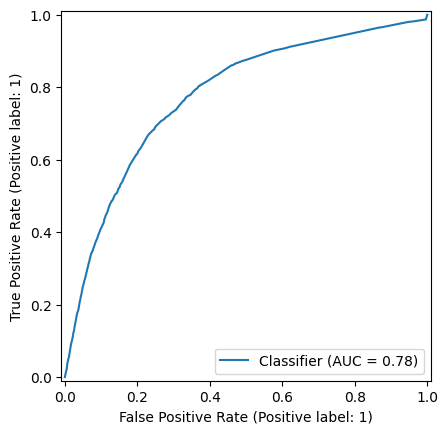

In [32]:
RocCurveDisplay.from_predictions(y_test, grid_search.best_estimator_.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [34]:
bagging_classifier = BaggingClassifier(n_estimators=50, max_samples=0.9, random_state=42)
bagging_classifier.fit(X_train_transformed, y_train)

y_pred_bagging = bagging_classifier.predict(X_test_transformed)

In [35]:
print(f"Accuracy (Bagging): {accuracy_score(y_test, y_pred_bagging)}")
print(f"Recall (Bagging): {recall_score(y_test, y_pred_bagging)}")
print(f"Precision (Bagging): {precision_score(y_test, y_pred_bagging)}")
print(f"AUC ROC (Bagging): {roc_auc_score(y_test, y_pred_bagging)}")

Accuracy (Bagging): 0.8394266175697002
Recall (Bagging): 0.15536409116175653
Precision (Bagging): 0.4725274725274725
AUC ROC (Bagging): 0.5614438859056414


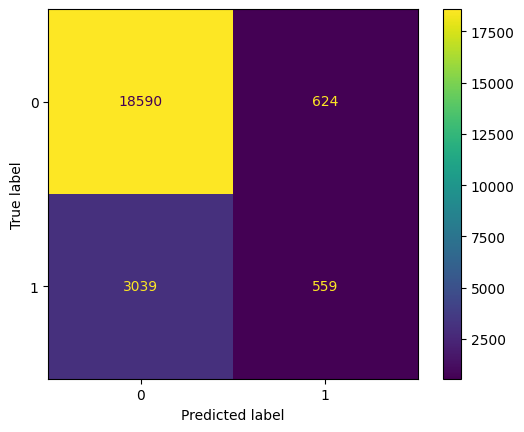

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bagging)
plt.show()

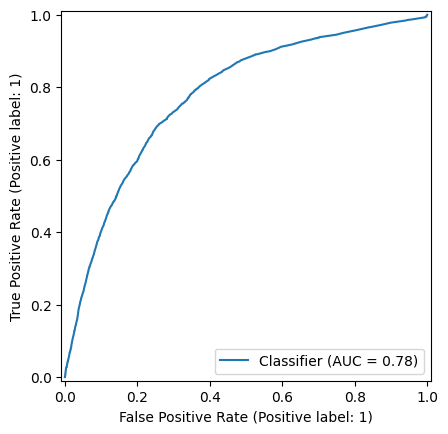

In [37]:
RocCurveDisplay.from_predictions(y_test, bagging_classifier.predict_proba(X_test_transformed)[:,1])
plt.show()

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?

In [51]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [52]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
param_grid_rf = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [57]:
grid_search_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid_rf, scoring='f1', cv=5)
grid_search_rf.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [58]:
best_params_rf = grid_search_rf.best_params_
print(f"Best hyperparameters for Random Forest: {best_params_rf}")

Best hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10}


In [59]:
best_rf_classifier = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf_classifier.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [60]:
y_pred_rf = best_rf_classifier.predict(X_test_transformed)
print(f"Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf)}")
print(f"Recall (Random Forest): {recall_score(y_test, y_pred_rf)}")
print(f"Precision (Random Forest): {precision_score(y_test, y_pred_rf)}")
print(f"AUC ROC (Random Forest): {roc_auc_score(y_test, y_pred_rf)}")

Accuracy (Random Forest): 0.8416184464317026
Recall (Random Forest): 0.13979988882712618
Precision (Random Forest): 0.4926542605288932
AUC ROC (Random Forest): 0.5564201900677735


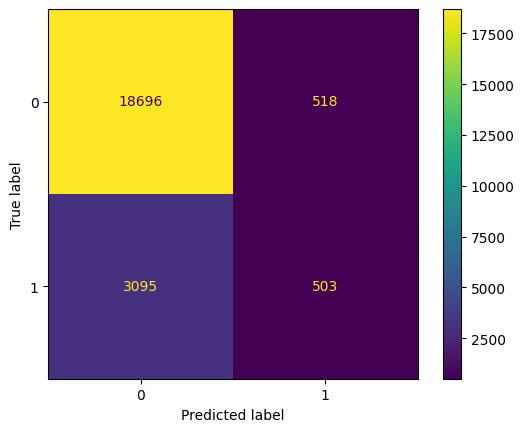

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()

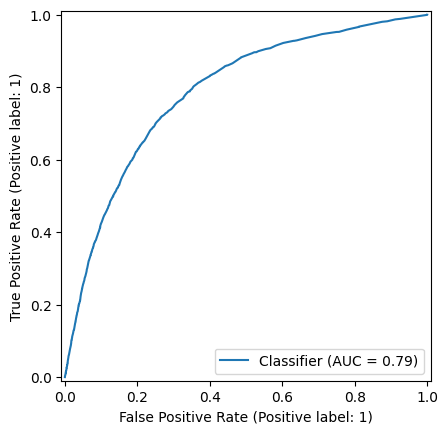

In [62]:
RocCurveDisplay.from_predictions(y_test, best_rf_classifier.predict_proba(X_test_transformed)[:,1])
plt.show()

The Random Forest model, despite having lower accuracy and precision, emerges as the potentially better model due to its significantly higher recall and improved AUC ROC score.

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

In [64]:
feature_importances = best_rf_classifier.feature_importances_
feature_names = X_train_transformed.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print("Most relevant features:")
feature_importance_df

Most relevant features:


,Feature,Importance
4,remainder__LengthOfStay,0.613233
5,remainder__AgeAtFirstClaim,0.143844
2,remainder__ClaimsTruncated,0.079821
3,remainder__CharlsonIndex,0.078983
1,OneHot__Sex_nan,0.072733
0,OneHot__Sex_M,0.011386


## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [40]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

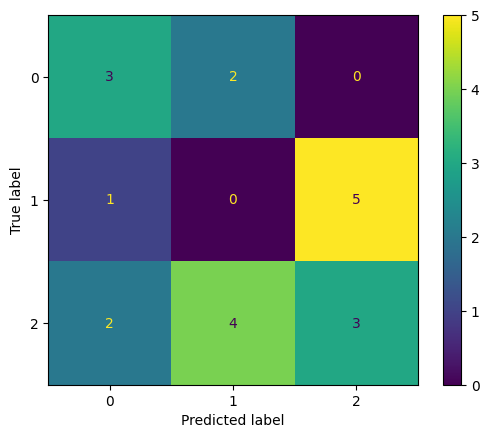

In [41]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [ ]:
#your code and variables like Pr1, Rec1, etc - no buit-in functions

In [43]:
from sklearn.metrics import confusion_matrix

def calculate_f1_score(y_true, y_pred, average='macro'):

  cm = confusion_matrix(y_true, y_pred)
  num_classes = cm.shape[0]

  if average == 'macro':
    f1_scores = []
    for i in range(num_classes):
      TP = cm[i, i]
      FP = np.sum(cm[:, i]) - TP
      FN = np.sum(cm[i, :]) - TP
      if TP == 0:
        f1_scores.append(0)
      else:
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        if precision + recall == 0:
          f1_scores.append(0)
        else:
          f1_scores.append(2 * (precision * recall) / (precision + recall))

    return np.mean(f1_scores)

  elif average == 'micro':
    TP = np.trace(cm)
    FP = np.sum(cm) - TP
    FN = np.sum(cm) - TP
    if TP == 0:
      return 0
    else:
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      if precision + recall == 0:
        return 0
      else:
        return 2 * (precision * recall) / (precision + recall)

  else:
    raise ValueError("Invalid averaging method")

In [46]:
f1_macro = calculate_f1_score(y_target, y_pred, average='macro')

In [47]:
from sklearn.metrics import make_scorer, f1_score

In [48]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [49]:
f1_micro = calculate_f1_score(y_target, y_pred, average='micro')

In [50]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5